# Deep FM : A Factorization-Machine based Neural Network for CTR Prediction

[원문링크] https://arxiv.org/pdf/1703.04247v1.pdf

## 요약
CTR(Click-through rate) 정의 : 클릭률(CTR)은 광고를 본 사용자가 해당 광고를 클릭하는 빈도의 비율입니다. 클릭율(CTR)을 사용하면 키워드와 광고, 무료 제품 목록의 실적을 파악할 수 있습니다.  
    * CTR은 광고가 클릭된 횟수를 광고가 게재된 횟수로 나눈 값입니다. (클릭수 / 노출수 = CTR)   
    [소스] https://support.google.com/google-ads/answer/2615875?hl=ko  
이 논문에서는 저차 및 고차 기능 상호 작용을 모두 강조하는 종단 간 학습 모델을 도출하는 것이 가능함을 보여줍니다.  
제안된 모델인 DeepFM은 새로운 신경망 아키텍처에서 추천을 위한 인수분해 기계의 성능(FM)과 학습을 위한 딥러닝(DNN)을 결합합니다.  
Google의 최신 Wide & Deep 모델과 비교할 때, DeepFM은 원시 기능 외에 기능 엔지니어링이 필요하지 않은 "Wide" 및 "Deep" feature에 대한 공유 입력을 가지고 있습니다.  
    * FM으로 low-order feature interactions을 학습하고, DNN으로 high-order feature interactions을 학습합니다.




## 소개  
![Example : DeepFM Architecture](https://www.researchgate.net/profile/Denis-Parra/publication/333072035/figure/fig8/AS:800143024603149@1567780371635/Example-of-the-DeepFM-Architecture-Image-adapted-from-3.ppm)

## 데이터 가져오기
MovieLens의 ml-1m 폴더에 있는 users, movies, ratings 데이터를 사용합니다.  
  
training data set이 n개의 (x, y) instances로 구성되어 있다고 가정한다.  
여기서는 x는 user, movie를 한 쌍(a pair)으로 포함하는 m개의 field data record이고, y는 rating을 나타낸다. (y는 1~5 사이의 정수를 0, 1로 구분)

In [138]:
# 데이터 가져오기

import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm

# 데이터 읽어 오기
user_cols = ["userId", "gender", "age", "Occupation", "zip_code"]
users = pd.read_csv("ml-1m/users.dat", sep='::', names=user_cols, engine='python')
movie_cols = ['movieId', 'title', 'genres']
movies = pd.read_csv('ml-1m/movies.dat', sep='::', names=movie_cols, encoding='ISO-8859-1', engine='python')
rating_cols = ['userId', 'movieId', 'rating', 'timestamp']
ratings = pd.read_csv('ml-1m/ratings.dat', sep='::', names=rating_cols, engine='python')

# timestamp 제거
ratings = ratings.drop('timestamp', axis=1)
# movie ID와 title 빼고 다른 데이터 제거
movies = movies[['movieId', 'title', 'genres']]
# user_id, age, gender, occupation 빼고 다른 데이터 제거
users = users[['userId', 'gender', 'age', 'Occupation','zip_code']]

|rating|user_id|age|gender|occupation|movie_id|title|
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|2|1|24|M|technician|1|Toy Story (1995)|
|5|1|24|M|technician|2|GoldenEye (1995)|


$x = [x_{field_{1}}, x_{field_{2}}, ... x_{field_{m}}]$ 
  
- categorical field(eg, gender, location)는 one-hot encoding된 vector로 표현  
- continous field(eg, age) field 값 자체로 or discretization 후 one-hot encoding된 vector로 표현        
  
예측하려는 y는 rating의 점수를 '0' 또는 '1'로 나누어서 binary classification을 수행한다.  
$y \in (0, 1)$  
  
CTR_Model은 x를 입력으로 받아서 y를 예측한다. 즉, 주어진 상황(x)에서 '0' 또는 '1'점수를 줄 확률을 예측한다.  
$\widehat{y}$ = CTR_Model(x) 

x data와 y data를 활용해 사용자가 특정 movie에 대해 rating point를 예측하는 모델을 만들어 보겠습니다. 



## FM 구성  

low-order feature interactions을 학습하기 위해 FM을 사용합니다.

![FM Architecture](https://velog.velcdn.com/images/aioptlab/post/66fcd506-a687-48b1-aef8-26e394775c13/image.png)  
  
$\displaystyle y_{FM} = <w, x> + \sum_{j_{1}=1}^d + \sum_{j_{2}=j_{1}+1}^d <v_{j1}, v_{j2}> x_{j1} x_{j2}$ $where$ $w \in R^d, v_{1} \in R^k$  

FM 모델은 order1-interaction을 포착하는 부분과 order2-interaction을 포함하는 부분으로 나누어집니다.  
이 모델은 order2-interaction의 가중치를 위에서 설명한 embedding vector의 내적이 됩니다.  
즉, FM 모델은 order1-interaction뿐만 아니라, 각 feature embedding vector의 inner product로 order2-interaction을 학습합니다.  
  
- 특징 : weight 대신 $v_{i}, v_{j}$ (latent_vector)를 사용합니다.

- 위 공식을 아래의 테이블로 표현하면 아래와 같습니다.

|Clicked|Publisher(P)|Advertiser(A)|Gender(G)|
|:---:|:---:|:---:|:---:|
|Yes|ESPN|Nike|Male|  

$w_{ESPN} + w_{Nike} \cdot w_{Male} + w_{Nike} \cdot w_{Male} ...$ . 
linear model 임의의 두 feature의 interaction을 구한 뒤 함께 연산  
기존 입력 모델의 features : publisher - E, Advertiser - N, Gender - M  
FM 모델의 features :  publisher - E, Advertiser - N, Gender - M, (publisher - E & Advertiser - N), (Advertiser - N, Gender - M) ...

## Deep Neural Network 구성 
high-order feature interactions을 학습하기 위해 DNN을 사용합니다.

![DNN Architecture](https://velog.velcdn.com/images/aioptlab/post/121fc571-81bc-4df5-89ce-e7527377bf55/image.png)  
  
Embedding vector가 FM 모델에서는 가중치의 역할을 했다면, DNN 모델에서는 input layer의 역할을 합니다.  
FM model을 통해 vector를 학습하기 때문에 pre-training이 필요없어 end-to-end로 학습할 수 있습니다.  
  
![Embedding Layer](https://velog.velcdn.com/images/aioptlab/post/9ffd642f-dc82-4de9-ac96-1249c307a784/image.png)  
embedding vector들을 합친 a(0)가 모델의 input이며, input을 H개의 층에 통과시켜 aH를 얻고, output layer(sigmoid 함수)를 통과한 값이 최종 결과입니다.  

- 참고로 이 때 FM model을 먼저 훈련하는 것이 아니고, 동시에 훈련에 같이 사용한다고 합니다.

## 영화 데이터를 활용한 예시  
- users, movies는 features로 사용하고, rating 컬럼은 예측할 타켓이 됩니다.  
- 이진분류형태로 훈련할 것이므로(BCE, Binary Cross Entropy) rating이 3점 이상이면 1, 3점 미만이면 0으로 바꿔줍니다. (이 영화를 추천할지 안할지 / 논문에서는 클릭 여부)

## 1. 데이터 전처리

### 1.1 rating data

In [139]:
# rating data 정보
ratings = ratings.copy()

ratings.head()

,userId,movieId,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [140]:
# rating이 3점 이상이면 1, 3점 미만이면 0으로 설정
ratings['click'] = ratings.rating.apply(lambda x: 1 if x >= 3 else 0)

ratings.drop('rating', axis=1, inplace=True)

ratings_df = ratings.copy()

ratings_df.head()

,userId,movieId,click
0,1,1193,1
1,1,661,1
2,1,914,1
3,1,3408,1
4,1,2355,1


<AxesSubplot:ylabel='Frequency'>

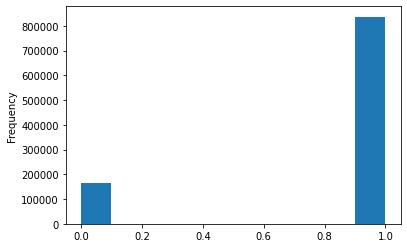

In [141]:
# ratings_df histogram
ratings_df.click.plot.hist()

### 1.2 movies data

In [142]:
# movie data 정보
movies_df = movies.copy()

print(movies_df.head())
print(movies_df.info())


   movieId                               title                        genres
0        1                    Toy Story (1995)   Animation|Children's|Comedy
1        2                      Jumanji (1995)  Adventure|Children's|Fantasy
2        3             Grumpier Old Men (1995)                Comedy|Romance
3        4            Waiting to Exhale (1995)                  Comedy|Drama
4        5  Father of the Bride Part II (1995)                        Comedy
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  3883 non-null   int64 
 1   title    3883 non-null   object
 2   genres   3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB
None


In [143]:
# dummy genres
genres_df = movies_df['genres'].str.get_dummies(sep='|')

genres_df

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3879,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3880,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3881,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [144]:
# movie data와 dummy genres data 합치기
movies_df.drop('genres', axis=1, inplace=True)
movies_df = pd.concat([movies_df, genres_df], axis=1)

movies_df.head()

,movieId,title,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [145]:
# year 추출
movies_df['year'] = movies_df.title.str.extract(('(\(\d\d\d\d\))'))
movies_df.year = movies_df.year.apply(lambda x: x.replace('(', '').replace(')', ''))
movies_df.year = movies_df.year.astype('int64')
movies_df.drop('title', axis=1, inplace=True)

movies_df.head()

,movieId,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1995
1,2,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1995
2,3,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1995
3,4,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1995
4,5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1995


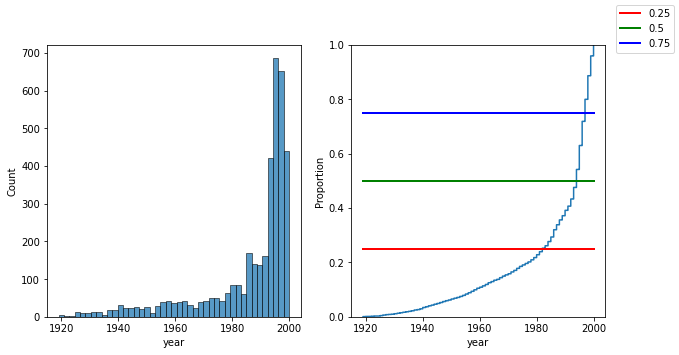

In [146]:
# year별 영화 개수
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

sns.histplot(movies_df.year, ax=ax1)
sns.ecdfplot(movies_df.year, ax=ax2)
ax2.plot([movies_df.year.min(), movies_df.year.max()], [0.25, 0.25], color='red', label='0.25', linewidth=2)
ax2.plot([movies_df.year.min(), movies_df.year.max()], [0.5, 0.5], color='green', label='0.5', linewidth=2)
ax2.plot([movies_df.year.min(), movies_df.year.max()], [0.75, 0.75], color='blue', label='0.75', linewidth=2)

fig.legend()

In [147]:
# cut by bins (year) [under 1980, 1980~1990, 1990~2000, 2000~]
bins = list(range(1980, movies_df.year.max()+1, 5))
bins.append(0)
bins = sorted(bins)

bins

[0, 1980, 1985, 1990, 1995, 2000]

In [148]:
# labels for bins
labels = list(range(len(bins)-1))
labels = ['year_' + str(i) for i in labels]

labels

['year_0', 'year_1', 'year_2', 'year_3', 'year_4']

In [149]:
# movies_df에 year_cut 추가
movies_df.year = pd.cut(movies_df.year, bins=bins, labels=labels, right=True)

movies_df

,movieId,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,year_3
1,2,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,year_3
2,3,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,year_3
3,4,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,year_3
4,5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,year_3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878,3948,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,year_4
3879,3949,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,year_4
3880,3950,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,year_4
3881,3951,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,year_4


In [150]:
# dummy year
year_df = pd.get_dummies(movies_df.year)

movies_df = pd.concat([movies_df, year_df], axis=1)
movies_df.drop('year', axis=1, inplace=True)

movies_df.head()

,movieId,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,...,Romance,Sci-Fi,Thriller,War,Western,year_0,year_1,year_2,year_3,year_4
0,1,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,2,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,3,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
3,4,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,5,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### 1.3 user data

In [151]:
# user data 정보
users_df = users.copy()

users_df.head()

,userId,gender,age,Occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [152]:
# gender dummy
genders_df = pd.get_dummies(users_df.gender, prefix='gender')

genders_df.head()

,gender_F,gender_M
0,1,0
1,0,1
2,0,1
3,0,1
4,0,1


In [153]:
# users_df에 genders_df 추가
users_df = pd.concat([users_df, genders_df], axis=1)
users_df.drop('gender', axis=1, inplace=True)

users_df

,userId,age,Occupation,zip_code,gender_F,gender_M
0,1,1,10,48067,1,0
1,2,56,16,70072,0,1
2,3,25,15,55117,0,1
3,4,45,7,02460,0,1
4,5,25,20,55455,0,1
...,...,...,...,...,...,...
6035,6036,25,15,32603,1,0
6036,6037,45,1,76006,1,0
6037,6038,56,1,14706,1,0
6038,6039,45,0,01060,1,0


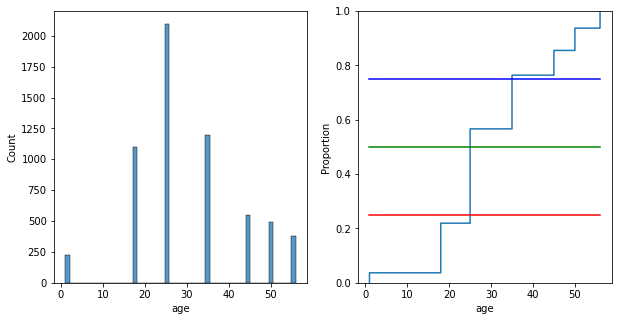

In [154]:
# age dummy ("1:Under 18", "18:18-24", "25:25-34", "35:35-44", "45:45-49", "50:50-55", "56:56+")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

sns.histplot(users_df.age, ax=ax1)
sns.ecdfplot(users_df.age, ax=ax2)
ax2.plot([users_df.age.min(), users_df.age.max()], [0.25, 0.25], color='red', label='0.25')
ax2.plot([users_df.age.min(), users_df.age.max()], [0.5, 0.5], color='green', label='0.5')
ax2.plot([users_df.age.min(), users_df.age.max()], [0.75, 0.75], color='blue', label='0.75')

In [155]:
# ages_df 생성
ages_df = pd.get_dummies(users_df.age, prefix='age')

ages_df.columns = ['under 18', '18-24', '25-34', '35-44', '45-49', '50-55', '56+']

ages_df

,under 18,18-24,25-34,35-44,45-49,50-55,56+
0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,1
2,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0
4,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...
6035,0,0,1,0,0,0,0
6036,0,0,0,0,1,0,0
6037,0,0,0,0,0,0,1
6038,0,0,0,0,1,0,0


In [156]:
# users_df에 ages_df 추가
users_df = pd.concat([users_df, ages_df], axis=1)

users_df.drop('age', axis=1, inplace=True)

users_df

,userId,Occupation,zip_code,gender_F,gender_M,under 18,18-24,25-34,35-44,45-49,50-55,56+
0,1,10,48067,1,0,1,0,0,0,0,0,0
1,2,16,70072,0,1,0,0,0,0,0,0,1
2,3,15,55117,0,1,0,0,1,0,0,0,0
3,4,7,02460,0,1,0,0,0,0,1,0,0
4,5,20,55455,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6035,6036,15,32603,1,0,0,0,1,0,0,0,0
6036,6037,1,76006,1,0,0,0,0,0,1,0,0
6037,6038,1,14706,1,0,0,0,0,0,0,0,1
6038,6039,0,01060,1,0,0,0,0,0,1,0,0


<AxesSubplot:xlabel='Occupation', ylabel='Count'>

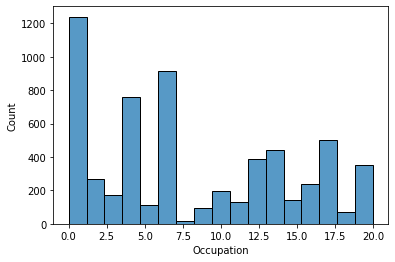

In [157]:
# Occupation dummy (Occupation : 0:other or not specified, 1:academic/educator, 2:artist, 3:clerical/admin, 4:college/grad student, 5:customer service, 6:doctor/health care, 7:executive/managerial, 8:farmer, 9:homemaker, 10:K-12 student, 11:lawyer, 12:programmer, 13:retired, 14:sales/marketing, 15:scientist, 16:self-employed, 17:technician/engineer, 18:tradesman/craftsman, 19:unemployed, 20:writer)
sns.histplot(users_df.Occupation)

In [158]:
occupations_name = ['other','academic/educator','artist','clerical/admin','college/grad student','customer service','doctor/health care','executive/managerial','farmer','homemaker','K-12 student','lawyer','programmer','retired','sales/marketing','scientist','self-employed','technician/engineer','tradesman/craftsman','unemployed','writer']

occupations_df = pd.get_dummies(users_df.Occupation)
occupations_df.columns = occupations_name

occupations_df

,other,academic/educator,artist,clerical/admin,college/grad student,customer service,doctor/health care,executive/managerial,farmer,homemaker,...,lawyer,programmer,retired,sales/marketing,scientist,self-employed,technician/engineer,tradesman/craftsman,unemployed,writer
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
6036,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6037,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6038,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [159]:
# users_df에 occupations_df 추가
users_df = pd.concat([users_df, occupations_df], axis=1)
users_df.drop('Occupation', axis=1, inplace=True)

users_df

,userId,zip_code,gender_F,gender_M,under 18,18-24,25-34,35-44,45-49,50-55,...,lawyer,programmer,retired,sales/marketing,scientist,self-employed,technician/engineer,tradesman/craftsman,unemployed,writer
0,1,48067,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,70072,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,3,55117,0,1,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,4,02460,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,55455,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035,6036,32603,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
6036,6037,76006,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6037,6038,14706,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6038,6039,01060,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


### 1.4 사용자, 영화, 평점 데이터 확인

In [160]:
# ratings data 정보
ratings_df.head()


,userId,movieId,click
0,1,1193,1
1,1,661,1
2,1,914,1
3,1,3408,1
4,1,2355,1


In [161]:
# movies data 정보
movies_df.head()

,movieId,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,...,Romance,Sci-Fi,Thriller,War,Western,year_0,year_1,year_2,year_3,year_4
0,1,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,2,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,3,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
3,4,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,5,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [162]:
# users data 정보
users_df.head()

,userId,zip_code,gender_F,gender_M,under 18,18-24,25-34,35-44,45-49,50-55,...,lawyer,programmer,retired,sales/marketing,scientist,self-employed,technician/engineer,tradesman/craftsman,unemployed,writer
0,1,48067,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,70072,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,3,55117,0,1,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,4,02460,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,55455,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


# 아래의 데이터를 활용해 FM과 DNN을 학습시키고, 예측해보고자 합니다.  
- 기존 코드의 user / movie 코드를 그대로 사용해 target을 예측하면 될 것 같습니다.

In [163]:
# 임베딩 파라미터
users_df = ratings["userId"].unique().tolist()
movies_df = ratings["movieId"].unique().tolist()

num_users = len(users_df)
num_movies = len(movies_df)

print('유저수 -> ', num_users)
print('영화수 -> ', num_movies)

유저수 ->  6040
영화수 ->  3706


In [164]:
# 학습/테스트 데이터 분할
from sklearn.model_selection import train_test_split

train, test = train_test_split(ratings, test_size=0.2)

### 모델 만들기

- 임베딩 단계  
![Embedding Layer](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fk.kakaocdn.net%2Fdn%2FcYyHxc%2FbtrvCmfMXCC%2FGQb8v9V3KZB6Z1eCraAQck%2Fimg.jpg)  

sparse 한 one-hot encoding data, continuous한 data를 각각 k차원으로 임베딩합니다.  
사용자 데이터 : 연령, 직업, 성별
영화 데이터 : 장르, 연도, 제목
- hidden layer로 전부 k차원으로 임베딩한 뒤, 각각의 임베딩 벡터를 합칩니다.
- embedding 된 k차원 벡터를 FM과 DNN에 input으로 넣어줍니다.  

In [165]:
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Flatten, Input, Dropout, Dense, Concatenate, Dot

# moive & user의 feature 차원
latent_dim = 32 # 왜 32 인가?

# tensorflow Embedding(input 차원의 최대값 그래서 +1을 함, 출력 차원)
movie_input = Input(shape=[1])
movie_embedding = Embedding(num_movies + 1, latent_dim)(movie_input) 
movie_vec = Flatten()(movie_embedding)

user_input = Input(shape=[1])
user_embedding = Embedding(num_users + 1, latent_dim)(user_input) 
user_vec = Flatten()(user_embedding)

### FM 
![FM](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fk.kakaocdn.net%2Fdn%2FlqoO1%2FbtrvAV9trFd%2FakabFvVAGELl9s0sgek8y0%2Fimg.png)  
  

- embedding matrix끼리 내적  
![order1, order2](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fk.kakaocdn.net%2Fdn%2FbcXsYd%2FbtrvIyeatn5%2FBDvbRGEQBJx1JLZ5Lw0ss0%2Fimg.png)  
  
  
order1 (addition) - linear interaction (해당 feature의 중요도)  
order2 (Inner product) - FM models pairwise interaction (feature간의 상호작용)  
  
output : YFM

### DNN
![DNN](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fk.kakaocdn.net%2Fdn%2FcTXmwz%2FbtrvIxTWKu5%2FFELbVo2F7TUYL4K1y4KTG0%2Fimg.png)  
  
  
$e_{1}, e_{2}, e_{m}$ : embedding layer를 통과한 각 feature의 embedding vector 값  
$a^{**}$(0) = m개의 embedding vector를 concat한 값  
  
output : YDNN

### 최종 output 
$\hat{y}$ = $sigmoid$($Y_{FM} + Y_{DNN}$)

In [166]:
### deep
concat = Concatenate(axis=1)([movie_vec,user_vec]) # concat -> 64 * 
concat_dropout = Dropout(0.2)(concat)
fc_1 = Dense(32, activation='relu')(concat_dropout)
fc_1_dropout = Dropout(0.2)(fc_1)
fc_2 = Dense(8, activation='relu')(fc_1_dropout)
fc_2_dropout = Dropout(0.2)(fc_2)
deep_out = Dense(1, activation='relu')(fc_2_dropout)
###

###fm
fm_out = Dot(axes=1)([movie_vec,user_vec])
###

deepfm_concat = keras.layers.Concatenate(axis=1)([fm_out, deep_out])

output = Dense(1, activation='sigmoid')(deepfm_concat) # 마지막에 원래 sigmoid 인거 같은데 output이 0~1사이가 아니어서 relu 사용 (sigmoid -> 0~1사이로 바꿔줌)

model = Model([user_input, movie_input], output)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.002), loss='binary_crossentropy', metrics=['accuracy'])

### 모델 그리기

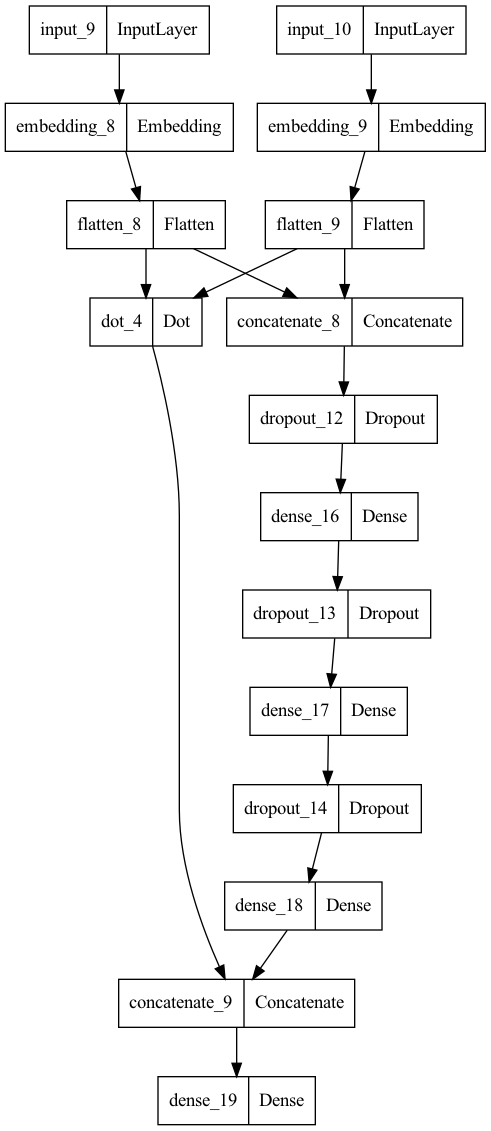

In [167]:
from tensorflow.keras.utils import plot_model

plot_model(model)

In [168]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_8 (Embedding)        (None, 1, 32)        118624      ['input_9[0][0]']                
                                                                                                  
 embedding_9 (Embedding)        (None, 1, 32)        193312      ['input_10[0][0]']               
                                                                                            

In [169]:
model.fit([train.userId, train.movieId], train.click, epochs=5,
                    batch_size=256, validation_data=([test.userId, test.movieId], test.click))

Epoch 1/5


2022-11-18 08:46:41.017761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


3126/3126 [==============================] - ETA: 0s - loss: 0.3714 - accuracy: 0.8448

2022-11-18 08:47:54.698709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


3126/3126 [==============================] - 77s 25ms/step - loss: 0.3714 - accuracy: 0.8448 - val_loss: 0.3428 - val_accuracy: 0.8583
Epoch 2/5
3126/3126 [==============================] - 79s 25ms/step - loss: 0.3324 - accuracy: 0.8622 - val_loss: 0.3362 - val_accuracy: 0.8612
Epoch 3/5
3126/3126 [==============================] - 80s 26ms/step - loss: 0.3037 - accuracy: 0.8722 - val_loss: 0.3420 - val_accuracy: 0.8601
Epoch 4/5
3126/3126 [==============================] - 81s 26ms/step - loss: 0.2616 - accuracy: 0.8901 - val_loss: 0.3682 - val_accuracy: 0.8522
Epoch 5/5
3126/3126 [==============================] - 78s 25ms/step - loss: 0.2265 - accuracy: 0.9061 - val_loss: 0.4010 - val_accuracy: 0.8474


## 평가

In [170]:
y_pred = model.predict([test.userId, test.movieId])
y_true = test.click

from sklearn.metrics import mean_squared_error

mean_squared_error(y_true, y_pred, squared=False)

2022-11-18 08:53:16.428177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


0.33944110742902156

### 적용 확인

In [171]:
print(test[:10])
print(y_pred[:10])

        userId  movieId  click
358545    2098      879      0
495213    3038     1230      1
84896      551     1224      1
462657    2854     3334      1
798356    4786     2953      1
572029    3507      413      0
124107     800      719      1
805667    4823     2858      1
632846    3824     1272      1
434460    2649     2371      1
[[0.8138745 ]
 [0.9952903 ]
 [0.99454266]
 [0.99929243]
 [0.32700297]
 [0.04465396]
 [0.29237035]
 [0.99799454]
 [0.9810977 ]
 [0.81911236]]
